## Исследование сгенерированного латентного пространства StyleGAN на основе датасета DEEPFASHION
#### Author: Sokolov Alexander

27.04.2022

## Contents:
* [Pre-work](#pre)
* [Data Load](#data)
* [EDA](#eda)
* [Генерация изображений из вектора Z-пространства](#generation)

# Pre-work <a class="anchor" id="pre"></a>

In [17]:
import pickle
import os
import numpy as np
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import IPython.display
import torch
import dnnlib
import legacy
import torch
import torchvision
import cv2
import os
import ffmpeg
import pandas as pd

# Data load  <a class="anchor" id="data"></a>

In [2]:
with open(r'E:\Users\onlym\Downloads\stylegan_human_v2_1024.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda()  # torch.nn.Module
z = torch.randn([1, G.z_dim]).cuda()    # latent codes
c = None                                # class labels (not used in this example)
img = G(z, c) 

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


In [3]:
w = G.mapping(z, c, truncation_psi=0.5, truncation_cutoff=8)
img = G.synthesis(w, noise_mode='const', force_fp32=True)

In [4]:
def seed2vec(G, seed):
  return np.random.RandomState(seed).randn(1, G.z_dim)

def display_image(image):
  plt.axis('off')
  plt.imshow(image)
  plt.show()

def generate_image(G, z, truncation_psi):
    # Render images for dlatents initialized from random seeds.
    Gs_kwargs = {
        'output_transform': dict(func=tflib.convert_images_to_uint8, 
         nchw_to_nhwc=True),
        'randomize_noise': False
    }
    if truncation_psi is not None:
        Gs_kwargs['truncation_psi'] = truncation_psi

    label = np.zeros([1] + G.input_shapes[1][1:])
    # [minibatch, height, width, channel]
    images = G.run(z, label, **G_kwargs) 
    return images[0]

def get_label(G, device, class_idx):
  label = torch.zeros([1, G.c_dim], device=device)
  if G.c_dim != 0:
      if class_idx is None:
          ctx.fail("Must specify class label with --class when using "\
            "a conditional network")
      label[:, class_idx] = 1
  else:
      if class_idx is not None:
          print ("warn: --class=lbl ignored when running on "\
            "an unconditional network")
  return label

def generate_image(device, G, z, truncation_psi=1.0, noise_mode='const', 
                   class_idx=None):
  z = torch.from_numpy(z).to(device)
  label = get_label(G, device, class_idx)
  img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(\
      torch.uint8)
  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')

In [5]:
device = torch.device('cuda')

# EDA  <a class="anchor" id="eda"></a>

In [ ]:
# Choose your own starting and ending seed.
SEED_FROM = 1000
SEED_TO = 1003

# Generate the images for the seeds.
for i in range(SEED_FROM, SEED_TO):
  print(f"Seed {i}")
  z = seed2vec(G, i)
  img = generate_image(device, G, z)
  display_image(img)

# Генерация изображений из вектора Z-пространства  <a class="anchor" id="generation"></a>

Теперь, когда мы загрузили нашу модель, можно сгенерировать случайный вектор.

начальные значения, используемые в модели StyleGAN, относятся к случайному начальному значению. Это позволяет нам генерировать одни и те же случайные значения каждый раз, пока начальное значение одинаково.

G.z_dim в большинстве случаев равен 512 (его можно настроить, поэтому мы берем его прямо из модели)

In [ ]:
seed = 120
z = np.random.RandomState(seed).randn(1, G.z_dim) 

print(z)

In [ ]:
z = torch.from_numpy(z).to(device)

In [ ]:
truncation_psi = 0.7
noise_mode = 'const' # 'const', 'random', 'none'
outdir = r"E:\Users\onlym\Downloads\gan_generated"

# make sure our output directory exists
os.makedirs(outdir, exist_ok=True)

# label is for class-based models. Let's assume we're not doing that here.
label = torch.zeros([1, G.c_dim], device=device)

img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
print(img)
img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
print(img)
PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'{outdir}/seed{seed:04d}.png')

In [6]:
def lerp(zs, steps):
    out = []
    for i in range(len(zs)-1):
        for index in range(steps):
            t = index/float(steps)
            out.append(zs[i+1]*t + zs[i]*(1-t))
    return out

In [ ]:
z1 = np.random.RandomState(20).randn(1, G.z_dim)
z2 = np.random.RandomState(100).randn(1, G.z_dim)
z3 = np.random.RandomState(200).randn(1, G.z_dim)
z4 = np.random.RandomState(300).randn(1, G.z_dim)
z5 = np.random.RandomState(400).randn(1, G.z_dim)
z6 = np.random.RandomState(500).randn(1, G.z_dim)
z7 = np.random.RandomState(600).randn(1, G.z_dim)
z8 = np.random.RandomState(700).randn(1, G.z_dim)

frame_zs = lerp([z1,z2,z3,z4,z5,z6,z7,z8], 50)

print('how many lerp frames? ',len(frame_zs))

outdir = r"E:\Users\onlym\Downloads\gan_generated"
os.makedirs(outdir, exist_ok=True)

# label is still 0
label = torch.zeros([1, G.c_dim], device=device)

for idx, z in enumerate(frame_zs):
    z = torch.from_numpy(z).to(device)
    print('Generating frame %d/%d' % (idx, len(frame_zs)))
    img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'{outdir}/frame-{idx:04d}.png')

In [ ]:
image_folder = r'E:\Users\onlym\Downloads\gan_generated'
video_name = r'E:\Users\onlym\Downloads\gan_generated\video1.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

In [ ]:
!ffmpeg -i E:\Users\onlym\Downloads\gan_generated\frame-%04d.png -r 24 -vcodec libx264 -pix_fmt yuv420p E:\Users\onlym\Downloads\gan_generated\lerp.mp4

In [9]:
def seed2vec(G, seed):
  return np.random.RandomState(seed).randn(1, G.z_dim)

def display_image(image):
  plt.axis('off')
  plt.imshow(image)
  plt.show()

def generate_image(G, z, truncation_psi):
    # Render images for dlatents initialized from random seeds.
    Gs_kwargs = {
        'output_transform': dict(func=tflib.convert_images_to_uint8, 
        nchw_to_nhwc=True),
        'randomize_noise': False
    }
    if truncation_psi is not None:
        Gs_kwargs['truncation_psi'] = truncation_psi

    label = np.zeros([1] + G.input_shapes[1][1:])
    # [minibatch, height, width, channel]
    images = G.run(z, label, **G_kwargs) 
    return images[0]

def get_label(G, device, class_idx):
  label = torch.zeros([1, G.c_dim], device=device)
  if G.c_dim != 0:
      if class_idx is None:
          ctx.fail('Must specify class label with --class'\
                   'when using a conditional network')
      label[:, class_idx] = 1
  else:
      if class_idx is not None:
          print ('warn: --class=lbl ignored when running '\
            'on an unconditional network')
  return label

def generate_image(device, G, z, truncation_psi=1.0, 
                   noise_mode='const', class_idx=None):
  z = torch.from_numpy(z).to(device)
  label = get_label(G, device, class_idx)
  img = G(z, label, truncation_psi=truncation_psi, 
          noise_mode=noise_mode)
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128)\
    .clamp(0, 255).to(torch.uint8)
  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')

In [10]:
URL = r'E:\Users\onlym\Downloads\stylegan_human_v2_1024.pkl'

In [11]:
device = torch.device('cuda')
with dnnlib.util.open_url(URL) as fp:
    G = legacy.load_network_pkl(fp)['G_ema']\
      .requires_grad_(False).to(device) 

Seed 200


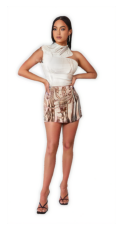

Seed 201


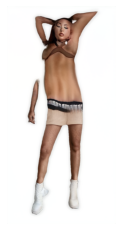

Seed 202


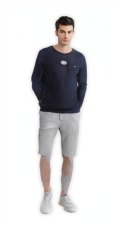

Seed 203


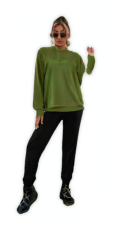

Seed 204


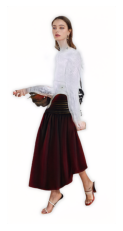

Seed 205


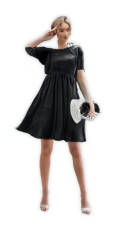

Seed 206


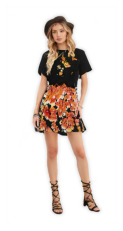

Seed 207


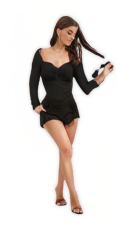

Seed 208


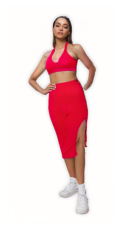

Seed 209


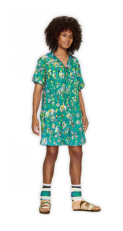

Seed 210


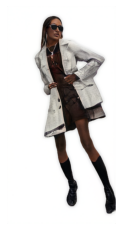

Seed 211


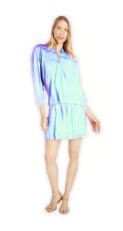

Seed 212


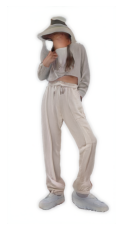

Seed 213


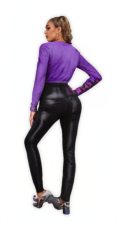

Seed 214


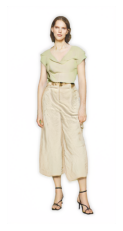

Seed 215


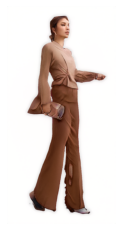

Seed 216


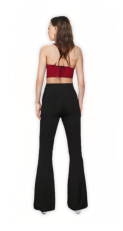

Seed 217


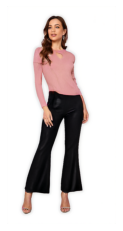

Seed 218


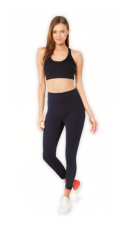

Seed 219


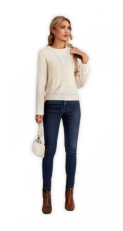

Seed 220


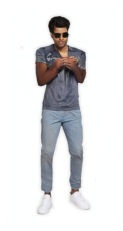

Seed 221


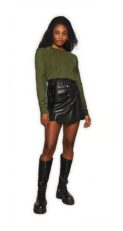

Seed 222


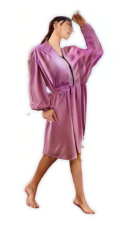

Seed 223


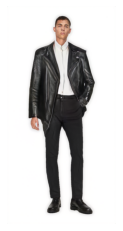

Seed 224


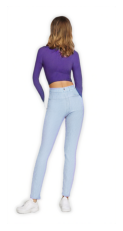

Seed 225


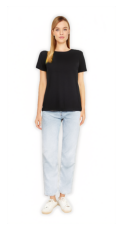

Seed 226


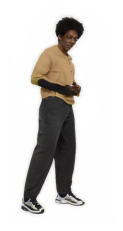

Seed 227


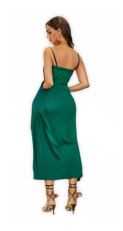

Seed 228


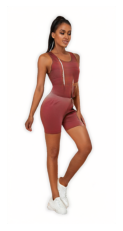

Seed 229


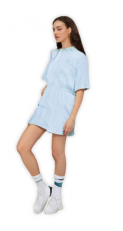

Seed 230


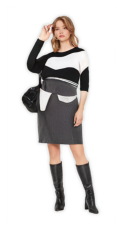

Seed 231


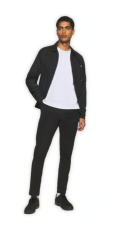

Seed 232


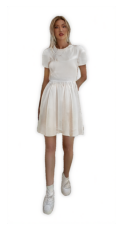

Seed 233


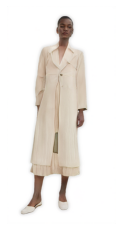

Seed 234


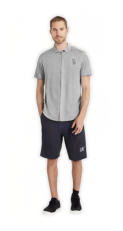

Seed 235


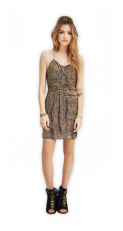

Seed 236


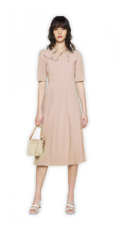

Seed 237


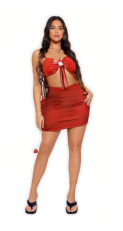

Seed 238


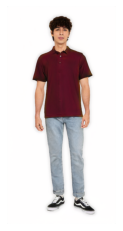

Seed 239


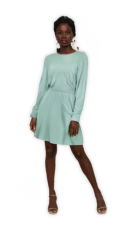

Seed 240


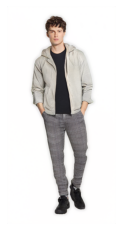

Seed 241


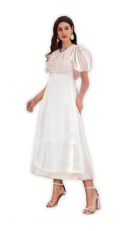

Seed 242


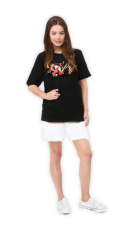

Seed 243


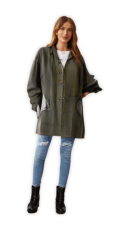

Seed 244


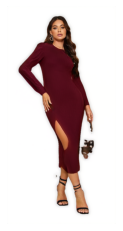

Seed 245


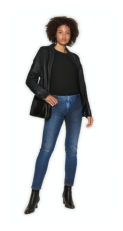

Seed 246


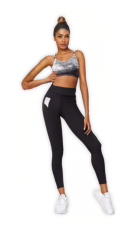

Seed 247


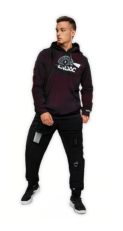

Seed 248


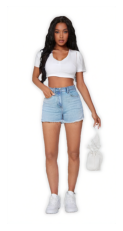

Seed 249


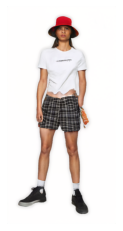

In [13]:
# HIDE OUTPUT 1
# Choose your own starting and ending seed.
SEED_FROM = 200
SEED_TO = 250

# Generate the images for the seeds.
for i in range(SEED_FROM, SEED_TO):
  print(f"Seed {i}")
  z = seed2vec(G, i)
  img = generate_image(device, G, z)
  display_image(img)

In [40]:
START_SEED = 248

current = seed2vec(G, START_SEED)

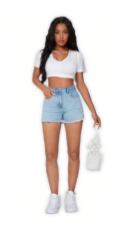

In [41]:
img = generate_image(device, G, current)

SCALE = 0.5
display_image(img)
img.save(r"E:\Users\onlym\Downloads\seed248\orig.jpg")

In [42]:
EXPLORE_SIZE = 10

explore = []
for i in range(EXPLORE_SIZE):
  explore.append( np.random.rand(1, 512) - 0.5 )

In [43]:
%config InlineBackend.figure_format = 'svg'

Direction 0


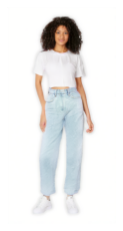

Direction 1


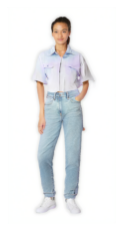

Direction 2


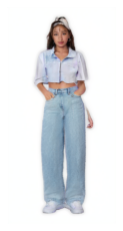

Direction 3


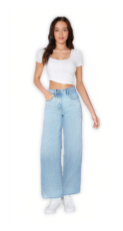

Direction 4


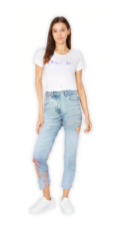

Direction 5


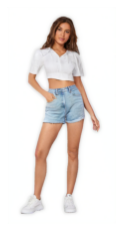

Direction 6


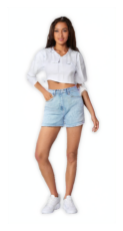

Direction 7


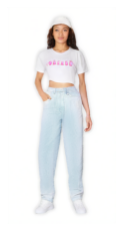

Direction 8


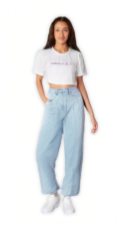

Direction 9


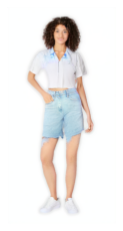

In [44]:
# HIDE OUTPUT 1
# Choose the direction to move.  Choose -1 for the initial iteration.   
MOVE_DIRECTION = 1
SCALE = -1

if MOVE_DIRECTION >=0:
  current = current + explore[MOVE_DIRECTION]

for i, mv in enumerate(explore):
    print(f"Direction {i}")
    z = current + mv
    img = generate_image(device, G, z)
    display_image(img)
    img.save(r"E:\Users\onlym\Downloads\seed248\%d.jpg"%(i+1))


In [ ]:
!pip install ninja

In [ ]:
import cv2
import numpy as np
from PIL import Image
import dlib

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')

def find_eyes(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  rects = detector(gray, 0)
  
  if len(rects) == 0:
    raise ValueError("No faces detected")
  elif len(rects) > 1:
    raise ValueError("Multiple faces detected")

  shape = predictor(gray, rects[0])
  features = []

  for i in range(0, 5):
    features.append((i, (shape.part(i).x, shape.part(i).y)))

  return (int(features[3][1][0] + features[2][1][0]) // 2, \
    int(features[3][1][1] + features[2][1][1]) // 2), \
    (int(features[1][1][0] + features[0][1][0]) // 2, \
    int(features[1][1][1] + features[0][1][1]) // 2)

def crop_stylegan(img):
  left_eye, right_eye = find_eyes(img)
  d = abs(right_eye[0] - left_eye[0])
  z = 255/d
  ar = img.shape[0]/img.shape[1]
  w = img.shape[1] * z
  img2 = cv2.resize(img, (int(w), int(w*ar)))
  bordersize = 1024
  img3 = cv2.copyMakeBorder(
      img2,
      top=bordersize,
      bottom=bordersize,
      left=bordersize,
      right=bordersize,
      borderType=cv2.BORDER_REPLICATE)

  left_eye2, right_eye2 = find_eyes(img3)

  crop1 = left_eye2[0] - 385 
  crop0 = left_eye2[1] - 490
  return img3[crop0:crop0+1024,crop1:crop1+1024]

In [ ]:
from matplotlib import pyplot as plt
import cv2

image_source = cv2.imread(SOURCE_NAME)
if image_source is None:
    raise ValueError("Source image not found")

image_target = cv2.imread(TARGET_NAME)
if image_target is None:
    raise ValueError("Source image not found")

cropped_source = crop_stylegan(image_source)
cropped_target = crop_stylegan(image_target)

img = cv2.cvtColor(cropped_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source')
plt.show()

img = cv2.cvtColor(cropped_target, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('target')
plt.show()

cv2.imwrite("cropped_source.png", cropped_source)
cv2.imwrite("cropped_target.png", cropped_target)

#print(find_eyes(cropped_source))
#print(find_eyes(cropped_target))